In [1]:
from univa.models.qwen2p5vl.modeling_univa_qwen2p5vl import UnivaQwen2p5VLForConditionalGeneration
import torch

from transformers import (
    AutoProcessor,
    SiglipImageProcessor,
    SiglipVisionModel,
    T5EncoderModel,
    BitsAndBytesConfig,
)

from univa.utils.flux_pipeline import FluxPipeline

from PIL import Image
from univa.utils.denoiser_prompt_embedding_flux import encode_prompt

from diffusers.utils import make_image_grid

from pathlib import Path
import json




/root/miniconda3/envs/univa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

LVLM_PATH = "/workspace/UniWorld-V1/model_weight/UniWorld-V1"
DENOISE_PROJECTOR_WEIGHT_PATH = "/workspace/UniWorld-V1/model_weight/denoise_projector.bin"
SIGLIP_PROJECTOR_WEIGHT_PATH = "/workspace/UniWorld-V1/model_weight/siglip_projector.bin"

SIGLIP_PATH = "/workspace/UniWorld-V1/model_weight/siglip2-so400m-patch16-512"
FLUX_PATH = "/workspace/UniWorld-V1/model_weight/FLUX.1-dev"

In [3]:
DATASET_FOLDER  = Path("/workspace/UniWorld-V1/training_data/uniworld_removal_dataset/19pLY9kqKFSXt2emZW16B6k3oBbTS9Tyh")

In [4]:
def get_img_and_clean_prompt(dataset_path: Path, idx: int):
    json_path = dataset_path / "annotation.json"


    with open(json_path, "r") as f:
        data = json.load(f)

    img_meta = data[idx]


    img_path = dataset_path / img_meta["image"][0]

    src_img = Image.open(img_path)
    clean_prompt = img_meta["conversations"][0]["value"]
    return src_img, clean_prompt




In [5]:


def load_siglip(siglip_path, device="cuda"):
    siglip_processor = SiglipImageProcessor.from_pretrained(siglip_path)
    siglip_model = SiglipVisionModel.from_pretrained(
        SIGLIP_PATH,
        torch_dtype=torch.bfloat16,
    ).to(device)
    return siglip_processor, siglip_model




def load_lvlm(pretrained_lvlm_name_or_path, denoise_projector_path, siglip_projector_path, device="cuda"):


    lvlm_model = UnivaQwen2p5VLForConditionalGeneration.from_pretrained(
        pretrained_lvlm_name_or_path,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
    ).to(device)
    

    # TODO: handle denoise_projector_path or siglip_projector_path is None
    denoise_projector = torch.load(denoise_projector_path)
    siglip_projector = torch.load(siglip_projector_path)

    msg = lvlm_model.load_state_dict(denoise_projector, strict=False)
    assert len(msg[1]) == 0, msg

    msg = lvlm_model.load_state_dict(siglip_projector, strict=False)
    assert len(msg[1]) == 0, msg

    lvlm_processor = AutoProcessor.from_pretrained(
        pretrained_lvlm_name_or_path,
        min_pixels=448 * 448,
        max_pixels=448 * 448,
    )

    return lvlm_processor, lvlm_model



def load_flux(flux_path, lvlm_model, device="cuda"):

    pipe = FluxPipeline.from_pretrained(
        flux_path,
        transformer=lvlm_model.denoise_tower.denoiser,
        torch_dtype=torch.bfloat16,
    ).to(device)

    return pipe

In [6]:
siglip_processor, siglip_model = load_siglip(SIGLIP_PATH)

lvlm_processor, lvlm_model = load_lvlm(LVLM_PATH, DENOISE_PROJECTOR_WEIGHT_PATH, SIGLIP_PROJECTOR_WEIGHT_PATH)
pipe = load_flux(FLUX_PATH, lvlm_model)

/tmp/ipykernel_189672/2614510602.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_projector = torch.load(denoise_projector_path)
/tmp/ipykernel_189672/2614510602

{'_attn_implementation_autoset': True, 'denoise_projector_type': 'mlp2x_gelu', 'denoiser_config': {'_class_name': 'FluxTransformer2DModel', '_diffusers_version': '0.30.0.dev0', '_name_or_path': '../checkpoints/flux-dev/transformer', 'attention_head_dim': 128, 'guidance_embeds': True, 'in_channels': 64, 'joint_attention_dim': 4096, 'num_attention_heads': 24, 'num_layers': 19, 'num_single_layers': 38, 'patch_size': 1, 'pooled_projection_dim': 768}, 'denoiser_type': 'flux', 'input_hidden_size': 3584, 'model_type': 'univa_denoise_tower', 'output_hidden_size': 4096, 'torch_dtype': 'float32', 'vae_input_hidden_size': 64, 'vae_projector_type': 'mlp2x_gelu'}
None
visual init done
model init done
denoise tower init done


Loading checkpoint shards: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]


In [9]:
def build_conversation(prompt, image, resolution=448):
    content = [
        {"type": "text", "text": prompt},
        {
            "type": "image",
            "image": image,
            "min_pixels": resolution * resolution,
            "max_pixels": resolution * resolution,
        },
    ]
    return [{"role": "user", "content": content}]


def preprocess_lvlm_inputs(lvlm_processor, convo, image, device="cuda"):

    chat_text = lvlm_processor.apply_chat_template(
        convo, tokenize=False, add_generation_prompt=True
    )
    chat_text = "<|im_end|>\n".join(chat_text.split("<|im_end|>\n")[1:])

    inputs = lvlm_processor(
        text=[chat_text],
        images=[image],
        padding=True,
        return_tensors="pt",
    ).to(device)
    return inputs


In [11]:


def get_siglip_hidden_states(siglip_processor, siglip_model, image, device="cuda"):
    tensor = siglip_processor.preprocess(
        image.convert("RGB"),
        do_resize=True,
        do_convert_rgb=True,
        return_tensors="pt",
    ).pixel_values.to(device)
    return siglip_model(tensor).last_hidden_state




In [23]:
# load image

test_img, prompt = get_img_and_clean_prompt(DATASET_FOLDER, 33)
test_img  = test_img.resize((448, 448))


convo = build_conversation(test_img, prompt)



# extract embeding

lvlm_inputs = preprocess_lvlm_inputs(lvlm_processor, convo, test_img)



siglip_hs = get_siglip_hidden_states(siglip_processor, siglip_model, test_img)


lvlm = lvlm_model(
    lvlm_inputs.input_ids,
    pixel_values=getattr(lvlm_inputs, "pixel_values", None),
    attention_mask=lvlm_inputs.attention_mask,
    image_grid_thw=getattr(lvlm_inputs, "image_grid_thw", None),
    siglip_hidden_states=siglip_hs,
    output_type="denoise_embeds",
)


# generater image

generator = torch.Generator(device="cuda")



tokenizers = [pipe.tokenizer, pipe.tokenizer_2]
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]

prompt_embeds = lvlm


empty_t5_prompt_embeds, empty_pooled_prompt_embeds = encode_prompt(
    text_encoders,
    tokenizers,
    prompt="",
    max_sequence_length=256,
    device="cuda",
    num_images_per_prompt=1,
)



image = pipe(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=empty_pooled_prompt_embeds,
    height=448,
    width=448,
    num_inference_steps=30,
    guidance_scale=4.0,
    generator=generator,
    num_images_per_prompt=1,
).images[0]

100%|██████████| 30/30 [00:06<00:00,  4.53it/s]


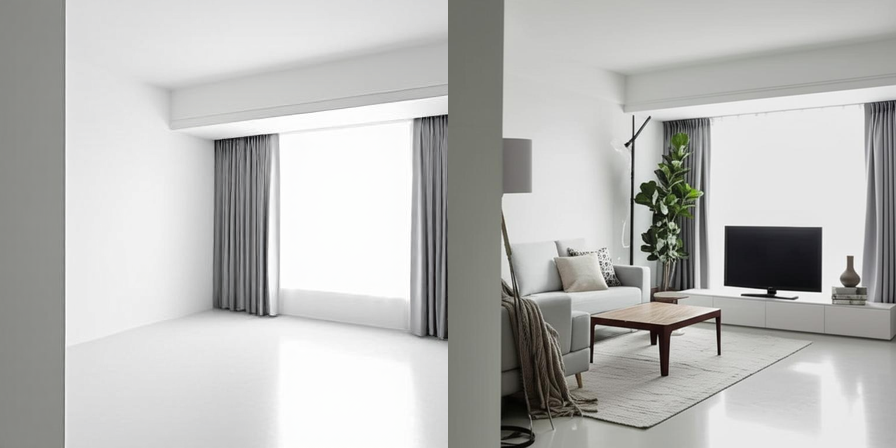

In [24]:
image = image.resize(test_img.size)

make_image_grid([image, test_img], cols=2, rows=1)